In [ ]:
# Torch - Torchvision - IceVision - IceData - MMDetection - YOLOv5 - EfficientDet Installation
!wget https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh

# Choose your installation target: cuda11 or cuda10 or cpu
!bash icevision_install.sh cuda11

!pip install sahi==0.10.8

!pip install -U pillow
import IPython
IPython.Application.instance().kernel.do_shutdown(True)


In [ ]:
# Download and Extract Dataset
!gdown 1e3NtzpwBcUeakcfiYo_gB2IgxxFIGkVe
!tar -xf CityCam.tar.gz

Downloading...
From: https://drive.google.com/uc?id=1e3NtzpwBcUeakcfiYo_gB2IgxxFIGkVe
To: /content/CityCam.tar.gz
100% 1.48G/1.48G [00:12<00:00, 119MB/s]


In [ ]:
!rm -r /content/CityCam/181
!rm -r /content/CityCam/572
!rm -r /content/CityCam/164
!rm -r /content/CityCam/166
!rm -r /content/CityCam/846
!rm -r /content/CityCam/928
!rm -r /content/CityCam/495

In [ ]:
# Dataset Preprocessing
import os
import cv2
from bs4 import BeautifulSoup
import pandas as pd


citycam_dir = './CityCam'
root_dir = sorted([os.path.join(citycam_dir,dir) for dir in os.listdir(citycam_dir) if dir != 'train_test_separation' ])
cam_dir = []
for root in root_dir:
  cam_dir += [os.path.join(root,dir) for dir in os.listdir(root) if os.path.isdir(os.path.join(root,dir))]

dataset = []
 
for dir in cam_dir:
  for f in os.listdir(dir):
    if '.jpg' in f:
      img = cv2.imread(os.path.join(dir,f))
      mask = cv2.imread(dir+'.png',0)
      res = cv2.bitwise_and(img,img,mask = mask)
      cv2.imwrite(os.path.join(dir,f),res)
    elif '.xml' in f:
      filename = os.path.join(dir,f)[:-4] + '.jpg'
      with open(os.path.join(dir,f), 'r') as x:
        data = x.read()
      Bs_data = BeautifulSoup(data, "xml")
      width = Bs_data.find('width').getText()
      height = Bs_data.find('height').getText()
    
      
      for v in Bs_data.findAll('vehicle'):
        data_row = dict(
          img_path = filename,
          width = int(width),
          height = int(height),
          label = 'vehicle',
          x_min = int(v.find('xmin').getText()),
          y_min = int(v.find('ymin').getText()),
          x_max = int(v.find('xmax').getText()),
          y_max = int(v.find('ymax').getText())
        )
        dataset.append(data_row)


df = pd.DataFrame.from_dict(dataset) 
df   



,img_path,width,height,label,x_min,y_min,x_max,y_max
0,./CityCam/170/170-20160429-15/000230.jpg,352,240,vehicle,74,88,84,97
1,./CityCam/170/170-20160429-15/000230.jpg,352,240,vehicle,79,90,93,103
2,./CityCam/170/170-20160429-15/000230.jpg,352,240,vehicle,97,91,107,102
3,./CityCam/170/170-20160429-15/000230.jpg,352,240,vehicle,115,91,128,102
4,./CityCam/170/170-20160429-15/000230.jpg,352,240,vehicle,104,97,121,107
...,...,...,...,...,...,...,...,...
603940,./CityCam/bigbus/bigbus-511/000089.jpg,352,240,vehicle,84,116,103,129
603941,./CityCam/bigbus/bigbus-511/000089.jpg,352,240,vehicle,199,110,215,120
603942,./CityCam/bigbus/bigbus-511/000089.jpg,352,240,vehicle,186,106,202,115
603943,./CityCam/bigbus/bigbus-511/000089.jpg,352,240,vehicle,106,144,133,167


In [ ]:
from icevision.all import *


No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


INFO     - Downloading default `.ttf` font file - SpaceGrotesk-Medium.ttf from https://raw.githubusercontent.com/airctic/storage/master/SpaceGrotesk-Medium.ttf to /root/.icevision/fonts/SpaceGrotesk-Medium.ttf | icevision.visualize.utils:get_default_font:70
INFO     - Downloading mmdet configs | icevision.models.mmdet.download_configs:download_mmdet_configs:31


0B [00:00, ?B/s]

In [ ]:
template_record = ObjectDetectionRecord()
Parser.generate_template(template_record)

class MyParser(Parser):
    def __init__(self, template_record):
        super().__init__(template_record=template_record)
    def __iter__(self) -> Any:
    def __len__(self) -> int:
    def record_id(self, o: Any) -> Hashable:
    def parse_fields(self, o: Any, record: BaseRecord, is_new: bool):
        record.set_filepath(<Union[str, Path]>)
        record.set_img_size(<ImgSize>)
        record.detection.add_bboxes(<Sequence[BBox]>)
        record.detection.set_class_map(<ClassMap>)
        record.detection.add_labels(<Sequence[Hashable]>)


In [ ]:
class VehicleParser(Parser):
    def __init__(self, template_record, df):
        super().__init__(template_record=template_record)


        self.df = df
        self.class_map = ClassMap(list(self.df['label'].unique()))

    def __iter__(self) -> Any:
        for o in self.df.itertuples():
            yield o

    def __len__(self) -> int:
        return len(self.df)

    def record_id(self, o) -> Hashable:
        return o.img_path

    def parse_fields(self, o, record, is_new):
        if is_new:
            record.set_filepath(o.img_path)
            record.set_img_size(ImgSize(width=o.width, height=o.height))
            record.detection.set_class_map(self.class_map)

        record.detection.add_bboxes([BBox.from_xyxy(o.x_min, o.y_min, o.x_max, o.y_max)])
        record.detection.add_labels([o.label])

In [ ]:
parser = VehicleParser(template_record, df)

In [ ]:
train_records, valid_records = parser.parse(cache_filepath='./parse_result')

  0%|          | 0/603945 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/42643 [00:00<?, ?it/s]

AUTOFIX-SUCCESS - (record_id: ./CityCam/170/170-20160429-18/000009.jpg) - Clipping bbox ymax from 241 to image height 240 (Before: <BBox (xmin:274, ymin:197, xmax:352, ymax:241)>) | icevision.utils.logger_utils:autofix_log:17
AUTOFIX-SUCCESS - (record_id: ./CityCam/170/170-20160429-18/000036.jpg) - Clipping bbox ymax from 241 to image height 240 (Before: <BBox (xmin:103, ymin:211, xmax:173, ymax:241)>) | icevision.utils.logger_utils:autofix_log:17
AUTOFIX-SUCCESS - (record_id: ./CityCam/170/170-20160429-18/000071.jpg) - Clipping bbox ymax from 241 to image height 240 (Before: <BBox (xmin:0, ymin:190, xmax:232, ymax:241)>) | icevision.utils.logger_utils:autofix_log:17
AUTOFIX-SUCCESS - (record_id: ./CityCam/170/170-20160502-18/000100.jpg) - Clipping bbox xmin from -1 to 0 (Before: <BBox (xmin:-1, ymin:44, xmax:9, ymax:72)>) | icevision.utils.logger_utils:autofix_log:17
AUTOFIX-SUCCESS - (record_id: ./CityCam/170/170-20160502-18/000100.jpg) - Clipping bbox xmin from -1 to 0 (Before: <BBo

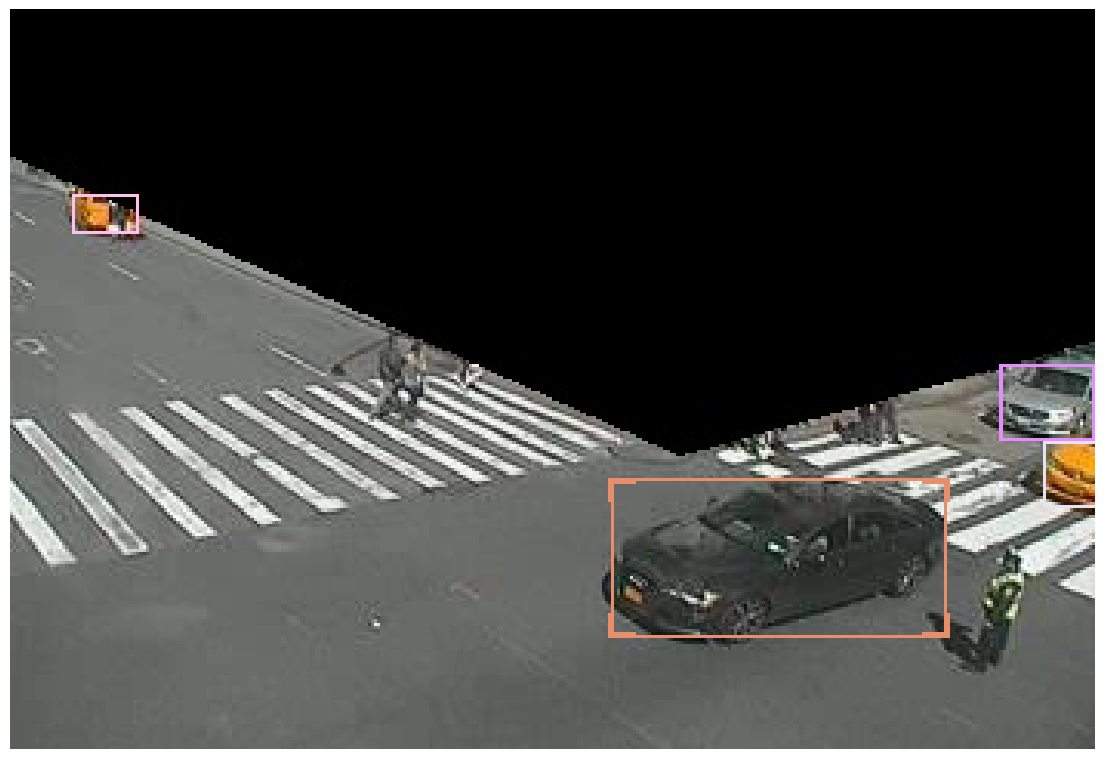

In [ ]:
show_record(train_records[0], display_label=False, figsize=(14, 10))

In [ ]:
train_records[0]

BaseRecord

common: 
	- Record ID: ./CityCam/170/170-20160508-15/000146.jpg
	- Filepath: CityCam/170/170-20160508-15/000146.jpg
	- Img: None
	- Image size ImgSize(width=352, height=240)
detection: 
	- BBoxes: [<BBox (xmin:321, ymin:115, xmax:351, ymax:139)>, <BBox (xmin:195, ymin:152, xmax:303, ymax:203)>, <BBox (xmin:335, ymin:140, xmax:352, ymax:161)>, <BBox (xmin:20, ymin:60, xmax:41, ymax:72)>]
	- Class Map: <ClassMap: {'background': 0, 'vehicle': 1}>
	- Labels: [1, 1, 1, 1]

In [ ]:
# Transforms
# size is set to 384 because EfficientDet requires its inputs to be divisible by 128
image_size = 384
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=image_size, presize=512), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(image_size), tfms.A.Normalize()])

In [ ]:
# Datasets
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

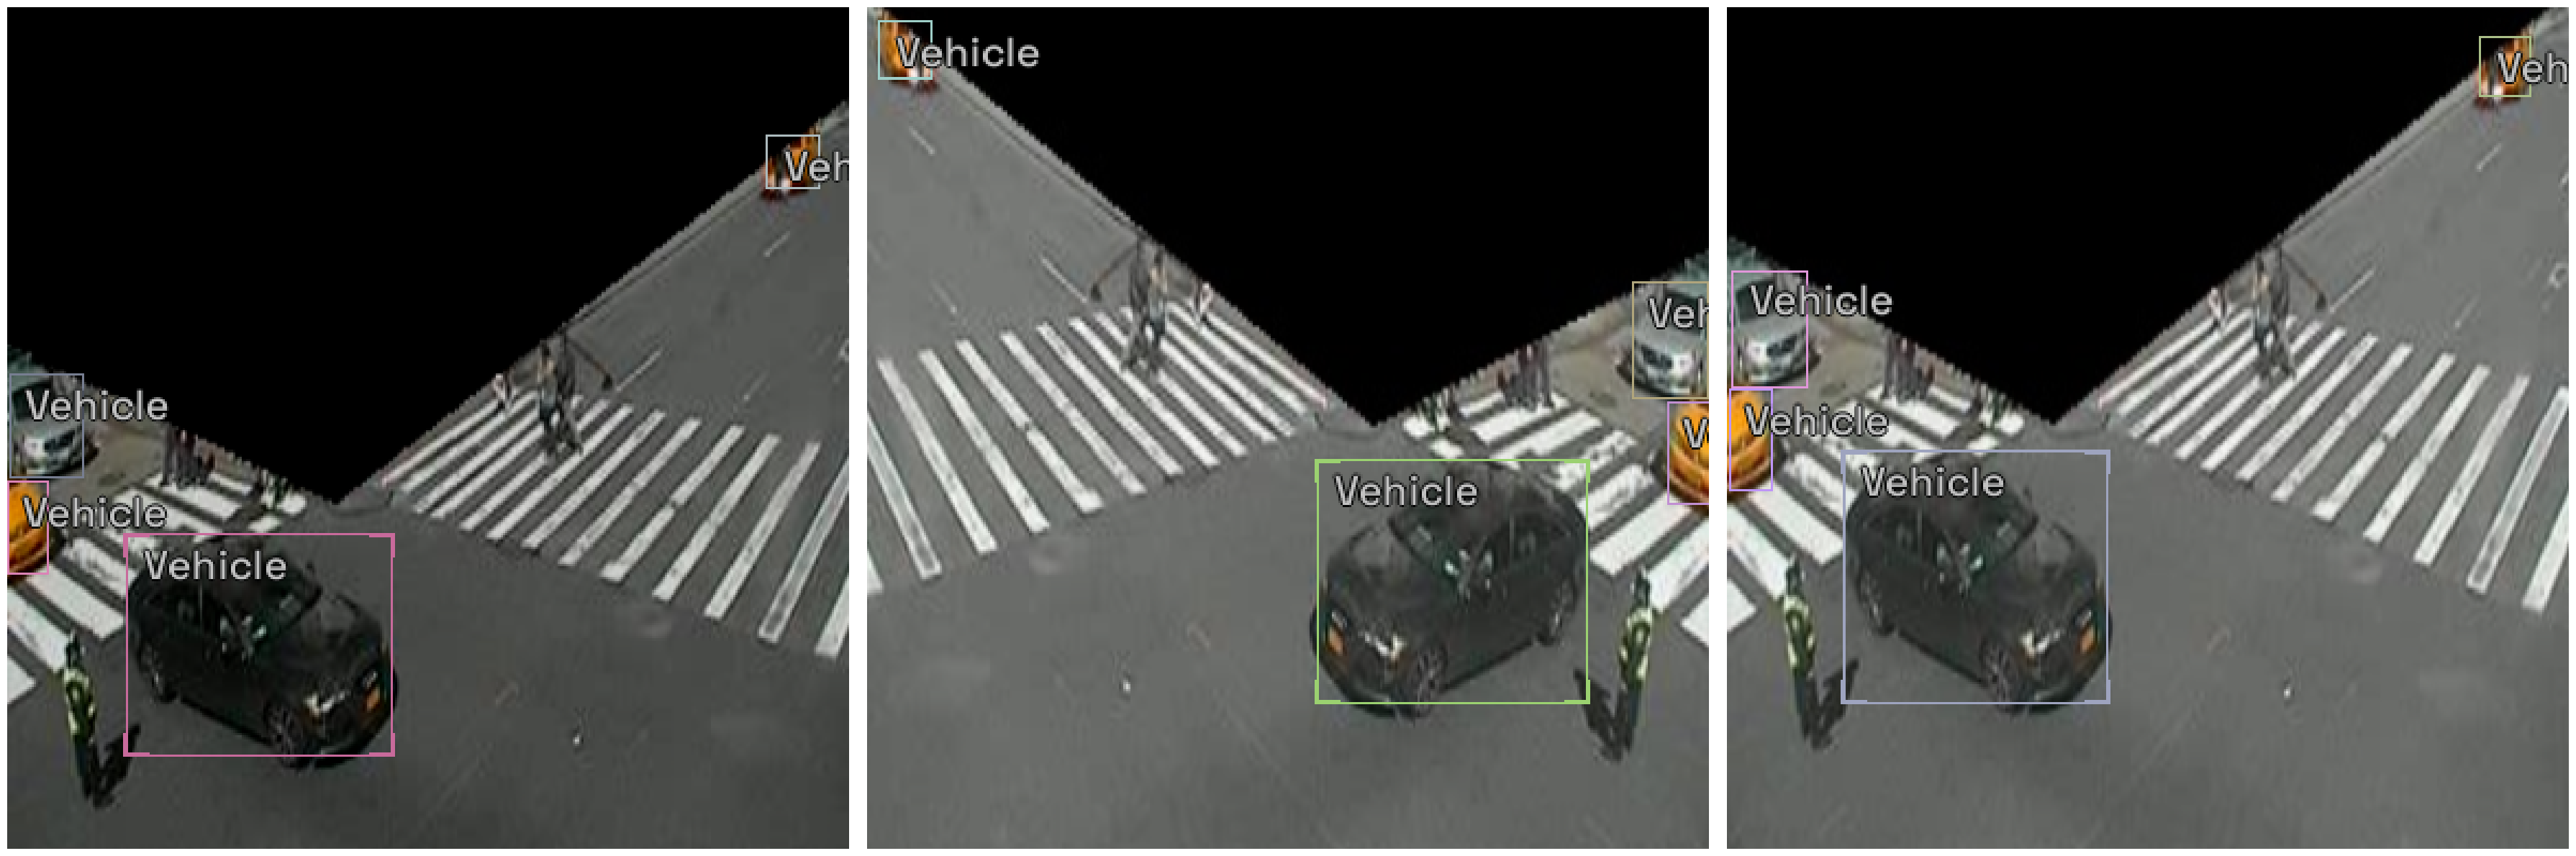

In [ ]:
# Show an element of the train_ds with augmentation transformations applied
samples = [train_ds[0] for _ in range(3)]
show_samples(samples, ncols=3)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df.to_csv('CityCam_Annotations.csv',index=False)

In [ ]:
!zip /content/drive/MyDrive/TSDN2022/vehicle_icevision_dataset_truncated.zip -r ./CityCam parse_result CityCam_Annotations.csv


Streaming output truncated to the last 5000 lines.
  adding: CityCam/173/173-20160503-18/000177.jpg (deflated 6%)
  adding: CityCam/173/173-20160503-18/000014.xml (deflated 88%)
  adding: CityCam/173/173-20160503-18/000183.jpg (deflated 7%)
  adding: CityCam/173/173-20160503-18/000183.xml (deflated 88%)
  adding: CityCam/173/173-20160503-18/000009.jpg (deflated 6%)
  adding: CityCam/173/173-20160503-18/000229.xml (deflated 88%)
  adding: CityCam/173/173-20160503-18/000175.jpg (deflated 6%)
  adding: CityCam/173/173-20160503-18/000267.xml (deflated 86%)
  adding: CityCam/173/173-20160503-18/000128.xml (deflated 89%)
  adding: CityCam/173/173-20160503-18/000277.xml (deflated 88%)
  adding: CityCam/173/173-20160503-18/000063.xml (deflated 88%)
  adding: CityCam/173/173-20160503-18/000207.jpg (deflated 6%)
  adding: CityCam/173/173-20160503-18/000151.jpg (deflated 6%)
  adding: CityCam/173/173-20160503-18/000030.xml (deflated 88%)
  adding: CityCam/173/173-20160503-18/000087.xml (deflated 